In [4]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


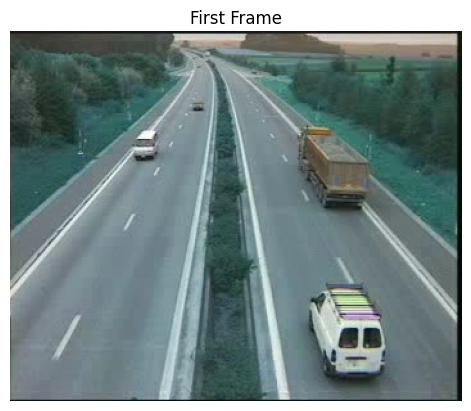

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def frame_differencing_first_frame(video_path, threshold):
    cap = cv2.VideoCapture(video_path)
    ret, first_frame = cap.read()
    plt.imshow(first_frame)
    plt.title('First Frame')
    plt.axis('off')
    plt.show()
    gray_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    count = 0
    frames = []
    frame_diffs = []
    thresholdeds = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frames.append(frame)

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Frame differencing
        diff_frame = np.abs(gray_frame.astype(np.int32) - gray_first_frame.astype(np.int32)).astype(np.uint8)
        frame_diffs.append(diff_frame)
        
        # Apply threshold
        thresholded = (diff_frame > threshold) * 255
        # cv2.imwrite('Data/result_frame_' + str(count) + '.png', thresholded)
        thresholdeds.append(thresholded)
        count += 1

    cap.release()
    return frames, thresholdeds, frame_diffs, count

video_path = '../Dataset/DatasetC.mpg'
frames, thresholdeds, frame_diff, frame_count = frame_differencing_first_frame(video_path, 30)



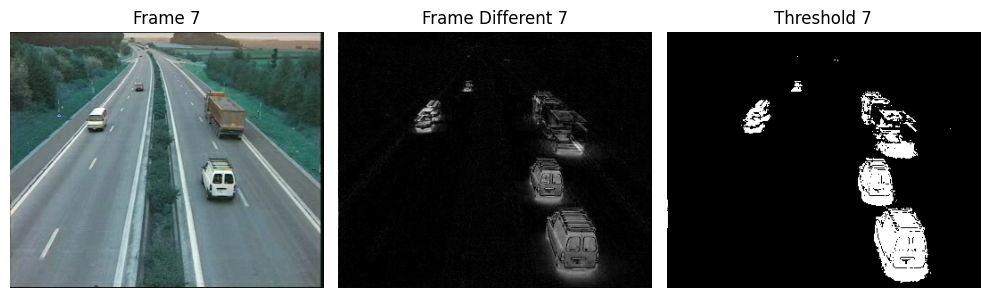

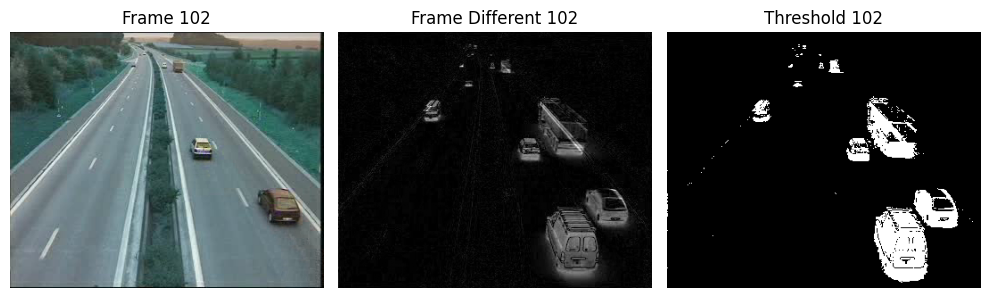

In [6]:
def show_frame(n, frames, frame_diff, thresholdeds):
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(frames[n])
    plt.title(f"Frame {n+2}")
    
    #Plot Equalized LBP window
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(frame_diff[n], cmap='gray')
    plt.title(f"Frame Different {n+2}")
    
    #Plot LBP Histogram
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(thresholdeds[n], cmap='gray')
    plt.title(f"Threshold {n+2}")
    
    plt.tight_layout()
    plt.show()

show_frame(5, frames, frame_diff, thresholdeds)
show_frame(100, frames, frame_diff, thresholdeds)

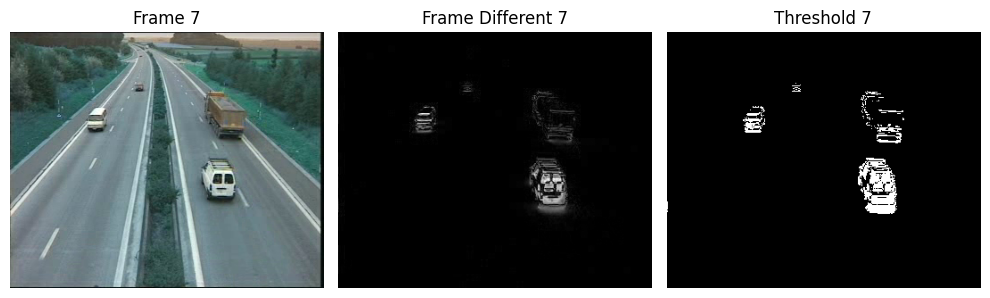

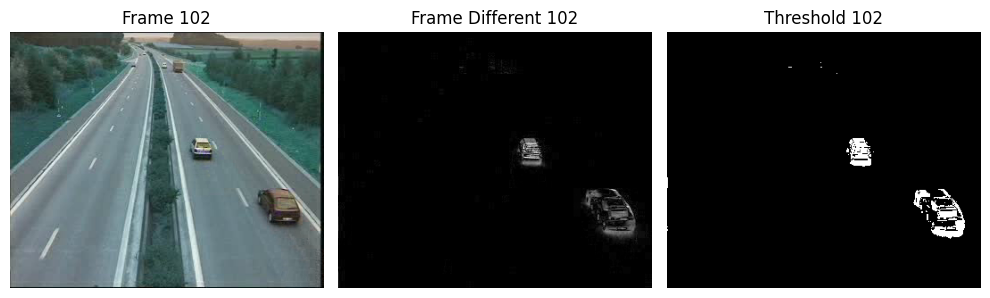

In [7]:
def frame_differencing_previous_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, previous_frame = cap.read()
    previous_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    count = 0
    frames = []
    frame_diffs = []
    thresholdeds = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # diff_frame = cv2.absdiff(previous_gray, gray)
        # _, thresholded = cv2.threshold(diff_frame, 30, 255, cv2.THRESH_BINARY)
        # cv2.imwrite('result_frame_' + str(count) + '.png', thresholded)
        diff_frame = np.abs(gray.astype(np.int32) - previous_gray.astype(np.int32)).astype(np.uint8)
        frame_diffs.append(diff_frame)
        thresholded = (diff_frame > 30) * 255
        thresholdeds.append(thresholded)
        count += 1

        previous_gray = gray.copy()

    cap.release()
    return frames, thresholdeds, frame_diffs

video_path = '../Dataset/DatasetC.mpg'
prev_frames, prev_thresholdeds, prev_frame_diff = frame_differencing_previous_frame(video_path)


show_frame(5, prev_frames, prev_frame_diff, prev_thresholdeds)
show_frame(100, prev_frames, prev_frame_diff, prev_thresholdeds)

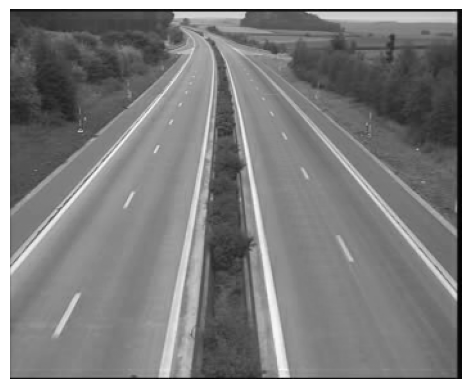

In [8]:
def generate_reference_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, first_frame = cap.read()
    avg_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY).astype('float')
    count = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype('float')
        
        # Accumulate the difference between the current frame and the average frame
        avg_frame += (gray_frame - avg_frame) / count
        count += 1

    background = avg_frame.astype(np.uint8)
    cap.release()
    
    return background


video_path = '../Dataset/DatasetC.mpg'
background = generate_reference_frame(video_path)
plt.imshow(background, cmap='gray')
plt.axis('off')
plt.show()

In [9]:

def label_connected_components(image):
    height, width = image.shape[:2]
    labels = np.zeros((height, width), dtype=np.uint32)  # Initialize labels matrix
    current_label = 1  # Starting label value
    
    # Function to get 16x16 connected neighboring labels
    def get_neighbor_labels(row, col):
        neighbors = []
        for r in range(max(0, row - 16), min(height, row + 17)):
            for c in range(max(0, col - 16), min(width, col + 17)):
                if image[r, c] == 255 and labels[r, c] != 0:
                    neighbors.append(labels[r, c])
        return neighbors
    
    # Labeling connected components
    for row in range(height):
        for col in range(width):
            if image[row, col] == 255:
                neighbor_labels = get_neighbor_labels(row, col)
                if not neighbor_labels:
                    labels[row, col] = current_label
                    current_label += 1
                else:
                    labels[row, col] = min(neighbor_labels)
    
    # Merge equivalent labels
    for row in range(height - 1, -1, -1):
        for col in range(width - 1, -1, -1):
            if image[row, col] == 255:
                neighbor_labels = get_neighbor_labels(row, col)
                current_label = labels[row, col]
                if neighbor_labels:
                    labels[row, col] = min(neighbor_labels)
                if labels[row, col] != current_label:
                    labels[labels == current_label] = labels[row, col]
    
    # Count the number of unique labels (excluding 0)
    num_objects = len(np.unique(labels)) - 1
    
    return num_objects



def count_moving_objects(video_path, background):
    cap = cv2.VideoCapture(video_path)
    count_objects = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Perform frame differencing
        diff_frame = np.abs(gray_frame.astype(np.int32) - background.astype(np.int32)).astype(np.uint8)
        
        # Apply a threshold
        thresholded = (diff_frame > 30) * 255
        
        # Count objects using connected component analysis
        num_objects = label_connected_components(thresholded)
        count_objects.append(num_objects)

    cap.release()
    return count_objects

video_path = '../Dataset/DatasetC.mpg'
count_objects= count_moving_objects(video_path, background)


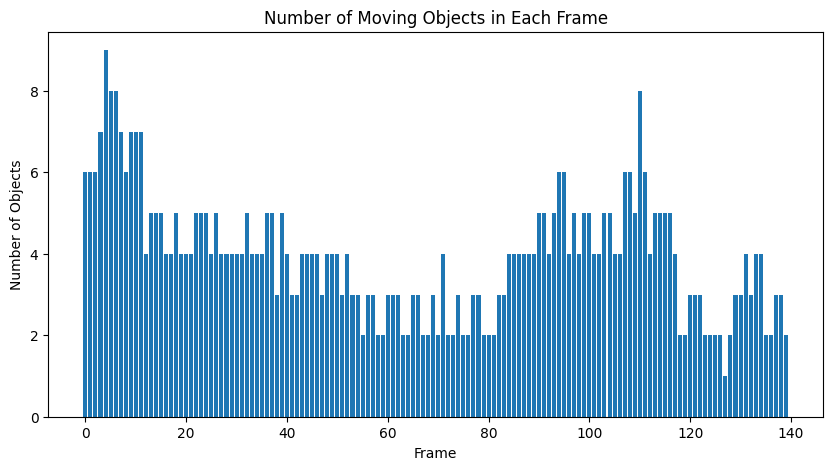

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(count_objects)), count_objects)
plt.xlabel('Frame')
plt.ylabel('Number of Objects')
plt.title('Number of Moving Objects in Each Frame')
plt.show()